# 코드 작성배경
* 배경에 관한 정보를 공통적으로 제공하여 학습을 진행하면 성능이 더 높아지지 않을까?

* 진행방식
 1. 데이터셋 이미지를 가져온다.
 2. 데이터셋 이미지를 opencv의 grabcut 알고리즘을 활용하여 background 제거
 3. 처리된 데이터를 명시된 주소에 저장하여 새로운 데이터셋 생성

# 오류 발생 시 진행해야 하는 부분
* cv2 관련 오류 발생한 경우
  1. 터미널에서 apt-get install libgl1-mesa-glx 실행 후 다시 코드 진행하기
  2. pip install opencv-python을 통해 버전 업데이트

* cv.imshow 관련
  ipynb 환경에서는 imshow가 새창을 띠우도록 되어있기 때문에 띄우기 위해서는 별도의 설정 필요

In [1]:
!pip install opencv-python

In [2]:
#사용 목적: loc을 통한 데이터 변형을 원 데이터에 적용하면 warning 발생
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
#영상 불러오기 위한 추가 라이브러리
import os #파일 불러오기 위한 코드
import cv2 #영상처리용 
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('input/data/train/train.csv')
eval = pd.read_csv('input/data/eval/info.csv')

In [6]:
#학습 데이터 주소 설정(위치가 다른 경우 변경하기)
train_path= 'input/data/train/images/'
eval_path= 'input/data/eval/images/'

# GrabCut 적용방식 확인해보기

In [7]:
for p in train['path']:
    file_list = os.listdir(train_path + p)

In [8]:
#listdir 사용하면 .으로 시작하는 숨김파일로 가져오기 때문에 아래 코드를 통해 숨김파일이 아닌 파일만 가져올 수 있음
file_list = [f for f in os.listdir(train_path + train['path'][0]) if not f.startswith('.')]
file_list

['normal.jpg',
 'incorrect_mask.jpg',
 'mask2.jpg',
 'mask3.jpg',
 'mask4.jpg',
 'mask1.jpg',
 'mask5.jpg']

## 원본 이미지 확인하기
 1. 여러 장의 이미지를 같은 window에 출력하기 위해서 plt.subplot() 활용
 2. file_list를 통해 각 폴더 내부의 이미지들을 가져와서 RGB를 BGR로 변경

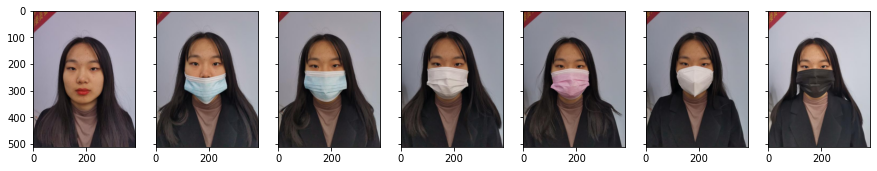

In [9]:
fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,12))
pos = 0
for list in file_list:
    img = cv2.imread(train_path + train['path'][1200] + '/'+ list, 1) #값을 변경하면서 다른 사람들의 사진도 확인
    axes[pos].imshow(img[:,:,::-1]) #채널 변경을 통한 원래 이미지에 맞는 출력이 나오도록 설정
    if img is None: #주소가 잘못된 경우를 알려주는 코드
        print('Image load failed')
        sys.exit()
    pos += 1
plt.show()

## GrabCut을 통한 배경 제거하기
 1. 여러 장의 이미지를 같은 window에 출력하기 위해서 plt.subplot() 활용
 2. file_list를 통해 각 폴더 내부의 이미지들을 가져와서 RGB를 BGR로 변경
 3. Grabcut을 통해 배경에 대한 mask 파일 생성
 4. mask 파일을 통해 배경 부분을 제거

### GrabCut parameter 설명
 : graph cut 기반 영역 분할 알고리즘 -> 미니멀 컷 알고리즘 이용해서 영역 분할
 * cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount, mode=None)
 1. img : 8비트 3채녈의 입력영상
 2. mask : 입출력
 3. rect : ROI 영역
 4. bgdModel : 임시 배경 모델 행렬(같은 영상 처리 시에는 변경 금지)
 5. fgdModel : 임시 전경 모델 행렬(같은 영상 처리 시에는 변경 금지)
 6. iterCount : 결과 생성을 위한 반복 횟수
 7. mode : cv2.GC_로 시작하는 모드 상수 ->현재 코드에서는 cv2.GC_INIT_WITH_RECT 모드로 초기화

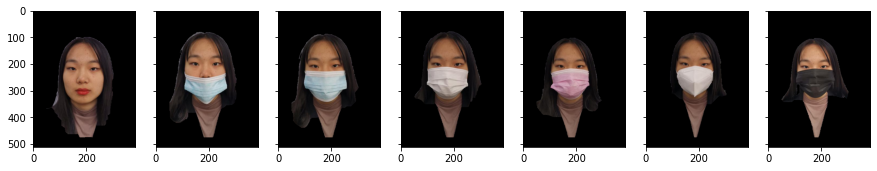

In [10]:
fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,12))
pos = 0
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rectangle = (50, 76, 250, 400)
for list in file_list:
   
    img = cv2.imread(train_path + train['path'][1200] + '/'+ list, 1) #값을 변경하면서 다른 사람들의 사진도 확인
    if img is None:
        print('Image load failed')
        sys.exit()
    pos += 1
    img = img[:,:,::-1] #채널 변경을 통한 원래 이미지에 맞는 출력이 나오도록 설정
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.grabCut(img, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    image_rgb_nobg = img * mask_2[:, :, np.newaxis]
    axes[pos].imshow(image_rgb_nobg) 
    
plt.show()

## GrabCut을 통한 배경 제거하고 배경 색상 일원화하기
  1. 여러 장의 이미지를 같은 window에 출력하기 위해서 plt.subplot() 활용
 2. file_list를 통해 각 폴더 내부의 이미지들을 가져와서 RGB를 BGR로 변경
 3. Grabcut을 통해 배경에 대한 mask 데이터 생성
 4. mask 데이터를 통해 배경 부분을 제거
 5. mask 데이터를 활욯하여 배경 부분을 동일한 색상으로 변경

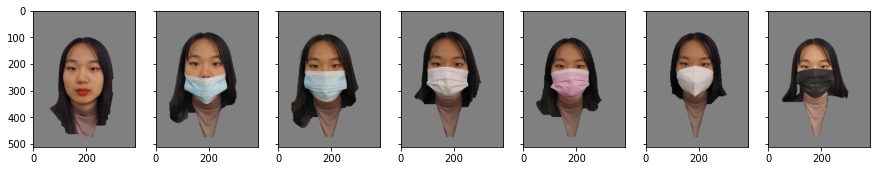

In [11]:
fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,12))
pos = 0
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rectangle = (50, 76, 250, 400)
for list in file_list:
   
    img = cv2.imread(train_path + train['path'][1200] + '/'+ list, 1)
    if img is None:
        print('Image load failed')
        sys.exit()
    pos += 1
    img = img[:,:,::-1] #채널 변경을 통한 원래 이미지에 맞는 출력이 나오도록 설정
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.grabCut(img, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    mask_3 = np.where((mask==2) | (mask==0), 128, 0).astype('uint8') #설정하는 값을 통해 배경 색상 변경 가능
    image_rgb_nobg = img * mask_2[:, :, np.newaxis]
    image_rgb_nobg = image_rgb_nobg + mask_3[:, :, np.newaxis]
    axes[pos].imshow(image_rgb_nobg) 
    
plt.show()

In [12]:
#각 환경에 맞추어서 path를 변경할 필요가 있음
if not os.path.exists('face_input'):
    os.mkdir('face_input')
if not os.path.exists('face_input/train'):
    os.mkdir('face_input/train')
if not os.path.exists('face_input/train/images'):
    os.mkdir('face_input/train/images')

In [ ]:
#train 데이터 grabcut 적용 코드
for specific_path in train['path']:
    if not os.path.exists('face_input/train/images/' + specific_path):
        os.mkdir('face_input/train/images/' + specific_path)
    file_list = [f for f in os.listdir(train_path + specific_path) if not f.startswith('.')]
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rectangle = (50, 76, 250, 400)
    for list in file_list:
        img = cv2.imread(train_path + specific_path + '/'+ list, 1) #데이터 읽어오는 부분
        mask = np.zeros(img.shape[:2], np.uint8)
        cv2.grabCut(img, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
        mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
        mask_3 = np.where((mask==2) | (mask==0), 128, 0).astype('uint8')
        image_rgb_nobg = img * mask_2[:, :, np.newaxis]
        image_rgb_nobg = image_rgb_nobg + mask_3[:, :, np.newaxis]
        cv2.imwrite('face_input/train/images/' + specific_path + '/'+ list, image_rgb_nobg) #데이터 저장하는 부분